In [40]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import matplotlib.pyplot as plt

In [41]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [42]:
from stocktrends import indicators

In [43]:
data={} # Dictionary to contain pandas dataframe for all the stocks. This is to avoid creating variable for each stock 
        # to store data
finalData={} # This should contain our final output and that is Renko OHLC data
n=7 # Period for ATR
renkoData={} # It contains information on the lastest bar of renko data for the number of stocks we are working on

In [44]:
def ATR(df,n): #df is the DataFrame, n is the period 7,14 ,etc
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR']=np.nan
    df.loc[df.index[n-1],'ATR']=df['TR'][:n-1].mean() #.ix is deprecated from pandas version- 0.19
    for i in range(n,len(df)):
        df['ATR'][i]=(df['ATR'][i-1]*(n-1)+ df['TR'][i])/n
    return

In [45]:
StockList=['JSWSTEEL', 'DLF']

In [46]:
start='2019-1-1'
for stock in StockList:
    data[stock]=pdr.get_data_yahoo(stock+'.NS', start)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [47]:
for stock in data:
    if data[stock].empty:
        print(stock)

In [48]:
for stock in data:
    print (stock, data[stock].head())

JSWSTEEL                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-01-01  308.899994  308.899994  302.500000  303.950012  294.597626   
2019-01-02  296.049988  297.950012  286.600006  288.700012  279.816833   
2019-01-03  287.500000  290.600006  280.299988  282.649994  273.953003   
2019-01-04  281.899994  289.450012  280.700012  287.950012  279.089905   
2019-01-07  292.299988  295.250000  288.149994  289.850006  280.931458   

              Volume  
Date                  
2019-01-01   3622654  
2019-01-02   8855139  
2019-01-03  10003388  
2019-01-04   6070751  
2019-01-07   7041362  
DLF                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-01-01  177.100006  182.149994  177.000000  180.300003  177.382294   
2019-01-02  179.899994  179.899994  172.250000  173.100006  170.298813   
2019-01-03 

In [49]:
for stock in data:
    data[stock].drop(data[stock][data[stock].Volume == 0].index, inplace=True) # Data Cleaning
    ATR(data[stock],n)
    data[stock]=data[stock][['Open','High','Low','Close','ATR']] # Removing unwanted columns

In [50]:
for stock in data:
    renkoData[stock]={'BrickSize':0.0, 'Open':0.0,'Close':0.0,'Color':''}

In [51]:
for stock in data:
    #renkoData[stock]['BrickSize']=round(data[stock]['ATR'][-1],2) #This can be set manually as well!
    renkoData['JSWSTEEL']['BrickSize'] = 1
    renkoData['DLF']['BrickSize'] = 1
    renkoData[stock]['Open']=renkoData[stock]['BrickSize']+renkoData[stock]['Close'] # This can be done the otherway round
                                                                                    # as well.'Close' = 'BrickSize' - 'Open' 
    renkoData[stock]['Color']='red'    # Should you choose to do the other way round, please change the color to 'green'

In [52]:
renkoData['JSWSTEEL']

{'BrickSize': 1, 'Open': 1.0, 'Close': 0.0, 'Color': 'red'}

In [53]:
renkoData['DLF']

{'BrickSize': 1, 'Open': 1.0, 'Close': 0.0, 'Color': 'red'}

In [54]:
for stock in data:
    finalData[stock]=pd.DataFrame()
    finalData[stock].index.name='Date'
    finalData[stock]['ReOpen']=0.0
    finalData[stock]['ReHigh']=0.0
    finalData[stock]['ReLow']=0.0
    finalData[stock]['ReClose']=0.0
    finalData[stock]['Color']=''

In [55]:
for stock in data: # This loops thorugh all the stocks in the data dictionary
    for index,row in data[stock].iterrows(): # One may choose to use Pure python instead of Iterrows to loop though each n 
                                         # every row to improve performace if datasets are large.
        if renkoData[stock]['Open']> renkoData[stock]['Close']: 
            while row['Close']> renkoData[stock]['Open']+renkoData[stock]['BrickSize']:
                renkoData[stock]['Open']+=renkoData[stock]['BrickSize']
                renkoData[stock]['Close']+=renkoData[stock]['BrickSize']
                finalData[stock].loc[index]=row
                finalData[stock]['ReOpen'].loc[index]= renkoData[stock]['Close']         
                finalData[stock]['ReHigh'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['ReLow'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['ReClose'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['Color'].loc[index]='green'

            while row['Close'] < renkoData[stock]['Close']-renkoData[stock]['BrickSize']:
                renkoData[stock]['Open']-=renkoData[stock]['BrickSize']
                renkoData[stock]['Close']-=renkoData[stock]['BrickSize']
                finalData[stock].loc[index]=row
                finalData[stock]['ReOpen'].loc[index]= renkoData[stock]['Open']         
                finalData[stock]['ReHigh'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['ReLow'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['ReClose'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['Color'].loc[index]='red'
                
        else:
            while row['Close']< renkoData[stock]['Open']-renkoData[stock]['BrickSize']:
                renkoData[stock]['Open']-=renkoData[stock]['BrickSize']
                renkoData[stock]['Close']-=renkoData[stock]['BrickSize']
                finalData[stock].loc[index]=row
                finalData[stock]['ReOpen'].loc[index]= renkoData[stock]['Close']         
                finalData[stock]['ReHigh'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['ReLow'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['ReClose'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['Color'].loc[index]='red'
                
            while row['Close'] > renkoData[stock]['Close']+renkoData[stock]['BrickSize']:
                renkoData[stock]['Open']+=renkoData[stock]['BrickSize']
                renkoData[stock]['Close']+=renkoData[stock]['BrickSize']
                finalData[stock].loc[index]=row
                finalData[stock]['ReOpen'].loc[index]= renkoData[stock]['Open']         
                finalData[stock]['ReHigh'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['ReLow'].loc[index]=renkoData[stock]['Open']
                finalData[stock]['ReClose'].loc[index]=renkoData[stock]['Close']
                finalData[stock]['Color'].loc[index]='green'

In [56]:
finalData['JSWSTEEL'].head(5)

,ReOpen,ReHigh,ReLow,ReClose,Color
Date,,,,,
2019-01-01,302.0,303.0,302.0,303.0,green
2019-01-02,290.0,290.0,289.0,289.0,red
2019-01-03,284.0,284.0,283.0,283.0,red
2019-01-04,286.0,287.0,286.0,287.0,green
2019-01-07,288.0,289.0,288.0,289.0,green


In [57]:
finalData['DLF'].head(5)


,ReOpen,ReHigh,ReLow,ReClose,Color
Date,,,,,
2019-01-01,179.0,180.0,179.0,180.0,green
2019-01-02,175.0,175.0,174.0,174.0,red
2019-01-03,174.0,174.0,173.0,173.0,red
2019-01-04,174.0,175.0,174.0,175.0,green
2019-01-07,178.0,179.0,178.0,179.0,green


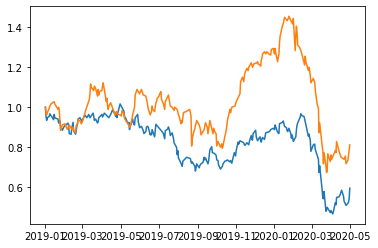

In [58]:
plt.plot(finalData['JSWSTEEL']['ReClose']/finalData['JSWSTEEL']['ReClose'][0])
plt.plot(finalData['DLF']['ReClose']/finalData['DLF']['ReClose'][0])

In [59]:
data['diff'] =((data['JSWSTEEL']['Close']/303.0)-(data['DLF']['Close']/180.0))*100

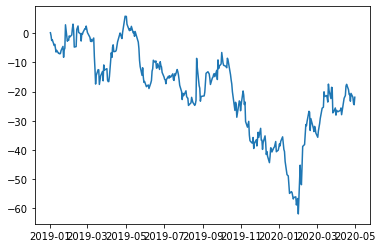

In [60]:
plt.plot(data['diff'])

In [61]:
v = 0
l = [v for i in range(len(data['diff']))]
for i in range(len(data['diff'])):
    for j in range(i):
        l[i] += data['diff'][j]

In [62]:
data['diff_c'] = l

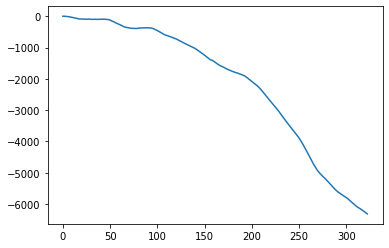

In [63]:
plt.plot(data['diff_c'])

In [64]:
df_a = pd.DataFrame.from_dict(data['JSWSTEEL'])
df_a = df_a[['Open','High','Low','Close']]
#df_a = df_a.columns.drop('Date')
df_a = df_a.reset_index()
# date_a = df_a.index
# date_a = pd.to_datetime(date_a)
# df_a = df_a.reset_index()
# df_a['date'] = date_a
df_a.columns = [i.lower() for i in df_a.columns]

In [65]:
df_a.columns

Index(['date', 'open', 'high', 'low', 'close'], dtype='object')

In [66]:
df_b = pd.DataFrame.from_dict(data['DLF'])
df_b = df_b[['Open','High','Low','Close']]
df_b = df_b.reset_index()
# date_b = df_b.index
# date_b = pd.to_datetime(date_b)
# df_b = df_b.reset_index()
# df_b['date'] = date_b
df_b.columns = [i.lower() for i in df_b.columns]

In [67]:
df_b.columns

Index(['date', 'open', 'high', 'low', 'close'], dtype='object')

In [68]:
rows = 5

In [69]:
lb_a = indicators.LineBreak(df_a)

print('\n\nJSWSTEEL Line break chart')
lb_a.line_number = 3
data_lb_a = lb_a.get_ohlc_data()
print(data_lb_a.tail(rows))

lb_b = indicators.LineBreak(df_b)

print('\n\nDLF Line break chart')
lb_b.line_number = 3
data_lb_b = lb_b.get_ohlc_data()
print(data_lb_b.tail(rows))



JSWSTEEL Line break chart
    index       date        open        high         low       close  uptrend
93      0 2020-04-15  167.649994  171.399994  167.649994  171.399994     True
94      0 2020-04-17  171.399994  177.300003  171.399994  177.300003     True
95      0 2020-04-21  171.399994  171.399994  159.600006  159.600006    False
96      0 2020-04-24  159.600006  159.600006  153.250000  153.250000    False
97      0 2020-04-30  159.600006  180.649994  159.600006  180.649994     True


DLF Line break chart
     index       date        open        high         low       close  uptrend
103      0 2020-03-19  140.149994  140.149994  128.449997  128.449997    False
104      0 2020-03-23  128.449997  128.449997  126.150002  126.150002    False
105      0 2020-03-24  126.150002  126.150002  120.800003  120.800003    False
106      0 2020-04-07  126.150002  141.550003  126.150002  141.550003     True
107      0 2020-04-09  141.550003  149.100006  141.550003  149.100006     True


In [70]:
lb_chart_a = data_lb_a[['close']]
date_time_a = data_lb_a['date']
date_time_a = pd.to_datetime(date_time_a)
lb_chart_a = lb_chart_a.set_index(date_time_a)

lb_chart_b = data_lb_b[['close']]
date_time_b = data_lb_b['date']
date_time_b = pd.to_datetime(date_time_b)
lb_chart_b = lb_chart_b.set_index(date_time_b)

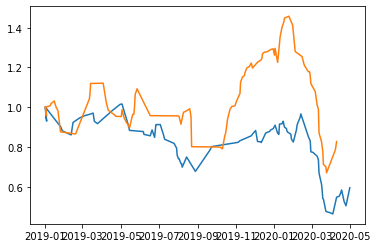

In [71]:
plt.plot(lb_chart_a/lb_chart_a['close'][0])
plt.plot(lb_chart_b/lb_chart_b['close'][0])

In [72]:
df1 = pd.DataFrame.from_dict(data['JSWSTEEL'])
df2 = pd.DataFrame.from_dict(data['DLF'])

In [73]:
df1['ratio'] = (df1['Close']/df1['Close'][0])/(df2['Close']/df2['Close'][0])
df2['ratio'] = (df2['Close']/df2['Close'][0])/(df1['Close']/df1['Close'][0])

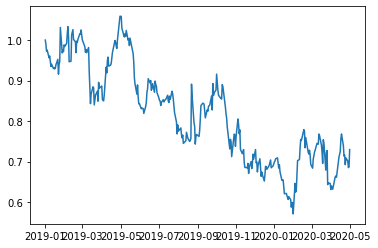

In [74]:
plt.plot(df1['ratio'])

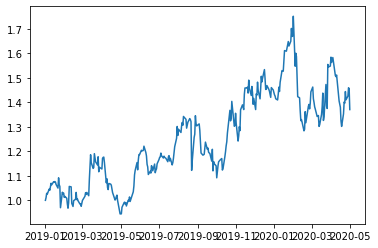

In [75]:
plt.plot(df2['ratio'])

In [76]:
'''JSW AND DLF'''

'JSW AND DLF'